### Keras Starter 

In [50]:
import bcolz
import numpy as np
import pickle 
from pathlib import Path
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
layers = keras.layers
from keras import metrics
import clr_callback
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.log_device_placement=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)
import matplotlib.pyplot as plt

In [2]:
model_path = Path('/home/ubuntu/WesternPower-Smartmeter/models/')
model_path.mkdir(exist_ok=True)

In [3]:
#load the column value dictionary
with open("data/cat_map.pkl", "rb") as dictionary_file:
       cat_map = pickle.load(dictionary_file)

In [52]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [4]:
class BcolzDataGenerator(keras.utils.Sequence):
    def __init__(self, bcolz_directory, batch_size, start_indx, end_indx):
        'Initialization'
        self.da = bcolz.open(rootdir=bcolz_directory, mode='r') 
        self.batch_size = batch_size
        self.start_indx = start_indx
        self.end_indx = end_indx
        self.on_epoch_end()
    def __len__(self):
        'Denotes the number of batches per epoch'                  
        return int(np.floor((self.end_indx  - self.start_indx) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        end = self.current_indx+self.batch_size
        X = X=np.nan_to_num(self.da[self.current_indx:end])    
        X = np.delete(X,9,axis=1) # drop the timestamp column   
        Y = X[:,X.shape[1]-1] # The Label is the last column
        X = X[:,:-1]

        LCLid = X[:,0].astype('int32')
        Acorn_grouped = X[:,2].astype('int32')
        Acorn = X[:,3].astype('int32')
        X = X[:,9:].astype('int32') # these are the rest of the numeric columns
        self.current_indx = end
        return [LCLid,Acorn_grouped, Acorn,  X], Y 

    def on_epoch_end(self):
        self.current_indx = self.start_indx
 

In [19]:
def get_fcn_model(learning_rate):
    LCLid_Input = layers.Input(shape=(1,), dtype='int32', name='LCLid_Input')
    Acorn_grouped_Input = layers.Input(shape=(1,), dtype='int32', name='Acorn_grouped_Input')
    Acorn_Input = layers.Input(shape=(1,), dtype='int32', name='Acorn_Input')
    numeric_input = layers.Input(shape=(40,), dtype='float32', name='Numeric_input')
    e1 = layers.Embedding(unique_LCLid, 30,  input_length=1, trainable=True) (LCLid_Input)
    e2 = layers.Embedding(unique_Acorn_grouped, 30,  input_length=1, trainable=True) (Acorn_grouped_Input)
    e3 = layers.Embedding(unique_Acorn, 30,  input_length=1, trainable=True)(Acorn_Input)
    merged_e = layers.concatenate([e1, e2, e3], axis=-1)
    merged_e = layers.Flatten()(merged_e)
    x= layers.concatenate([merged_e, numeric_input], axis=-1)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    main_output = layers.Dense(1, activation='linear', name='main_output')(x)
    fcn_model = keras.Model(inputs=[LCLid_Input, Acorn_grouped_Input,Acorn_Input,numeric_input ], outputs=main_output)
    adm = keras.optimizers.Adam(lr=learning_rate)
    fcn_model.compile(optimizer=adm, loss='mse') # , metrics=[ metrics.mean_squared_error]
    return fcn_model

In [22]:
def train_model(mod):
    sess.run(tf.global_variables_initializer())
    mod.fit_generator(TG, epochs=num_epochs, validation_data =VG,  verbose=1,   callbacks=[
                        
                        keras.callbacks.ModelCheckpoint(str(model_path/'weights.{epoch:02d}-{val_loss:.2f}.hdf5'), 
                                                              monitor='val_loss', verbose=0, 
                                                             save_best_only=True, save_weights_only=False, 
                                                               mode='auto', period=1),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
                        ])

In [41]:
split=int(160e6)
split2=int(split+10e6)
split3=int(171e6)

batch_size = 10000
num_epochs=1000
patience=25
start=1
TG = BcolzDataGenerator('data/processed_main_sorted', batch_size, 1,split )
VG = BcolzDataGenerator('data/processed_main_sorted', batch_size, split, split2 )


In [26]:
# embedding columns = 'LCLid',  'Acorn_grouped', 'Acorn'
unique_LCLid = len(cat_map['LCLid'])
unique_Acorn_grouped = len(cat_map['Acorn_grouped'])
unique_Acorn = len(cat_map['Acorn'])

In [ ]:
fcn_model = get_fcn_model(0.001)
train_model(fcn_model)

In [59]:
fcn_model = get_fcn_model(0.0001)
fcn_model.load_weights('models/weights.14-0.11.hdf5')
#train_model(fcn_model)

In [67]:
fcn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
LCLid_Input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
Acorn_grouped_Input (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
Acorn_Input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 1, 30)        166980      LCLid_Input[0][0]                
__________________________________________________________________________________________________
embedding_

In [62]:
TestG = BcolzDataGenerator('data/processed_main_sorted', batch_size, split2, split3 )
preds = fcn_model.predict_generator(TestG, steps=10)

170000000

In [65]:
da = bcolz.open(rootdir='data/processed_main_sorted', mode='r')
y = da[split2:split2+(10*batch_size),-1:]
rmse_result = rmse(preds,y)
print ("RMSE is ", rmse_result )

RMSE is  0.261975


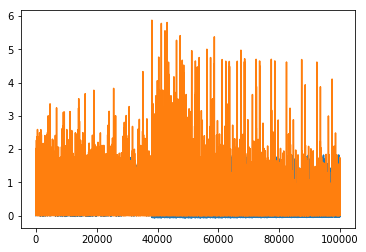

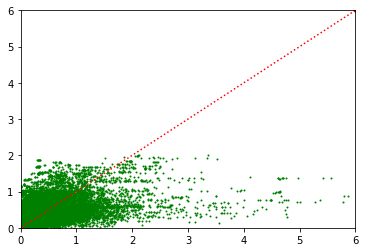

In [66]:
plt.plot(preds)
plt.plot(y)
plt.show()

plt.scatter(y, preds, c='green', s=1)
plt.plot([0,6],[0,6], c= "red", marker='.', linestyle=':')
plt.axis([0,6 , 0, 6])
plt.show()
